In [0]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import os

#print (os.listdir('/content/gdrive/My Drive/MILIZE/'))
print (os.listdir('/content/gdrive/My Drive/MILIZE/Semantic/voc2012/'))
print (os.listdir('/content/gdrive/My Drive/MILIZE/Semantic/voc2012/voc2012/'))

['train.txt', 'voc2012', 'list_12.csv', 'list_15.csv', 'u_net_vgg16_voc2012.ipynb']
['class', 'img']


Library

In [3]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

from PIL import Image

from sklearn.model_selection import train_test_split

from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Input, Dropout, Conv2D, Conv2DTranspose
from keras.layers import concatenate

from keras.callbacks import EarlyStopping

Using TensorFlow backend.


Get data 1

In [0]:
path_train = '/content/gdrive/My Drive/MILIZE/Semantic/voc2012/'
path_img = '/content/gdrive/My Drive/MILIZE/Semantic/voc2012/voc2012/img/'
path_class = '/content/gdrive/My Drive/MILIZE/Semantic/voc2012/voc2012/class/'

In [5]:
df_train = pd.read_table(path_train+'train.txt', header=None, names=('A'))
#df_train = pd.read_csv(path_train+'list_12.csv')

print (df_train.shape)
df_train.head()

(1464, 1)


,A
0,2007_000032
1,2007_000039
2,2007_000063
3,2007_000068
4,2007_000121


shape:  (256, 256, 3)


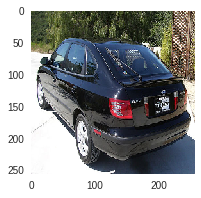

In [6]:
idx = np.random.randint(len(df_train))
#file_name = df_train['f'][idx]

file_name = df_train['A'][idx]
#file_name = '2008_003480'

size = 256

img_pil = Image.open(path_img+file_name+'.jpg').resize((size, size))
img_np = np.array(img_pil)

print ('shape: ', img_np.shape)

plt.figure(figsize=(5, 3))
plt.imshow(img_np)
plt.grid(False)
plt.show()

mode of class_pil:  P
mode of class_pil_rgb:  RGB
shape:  (256, 256)
shape:  (256, 256, 3)


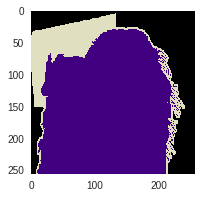

In [0]:
class_pil = Image.open(path_class+file_name+'.png').resize((size, size))
print ('mode of class_pil: ', class_pil.mode)

class_pil_rgb = class_pil.convert('RGB')
print ('mode of class_pil_rgb: ', class_pil_rgb.mode)

#palette = class_pil.getpalette()
# リストの値は index=0 から順番に [R, G, B, R, G, B, ...]

#palette = np.array(palette).reshape(-1, 3)
#print(palette.shape)  # (256, 3)

class_np = np.array(class_pil)
print ('shape: ', class_np.shape)
#print (class_np[120])

class_np_rgb = np.array(class_pil_rgb)
print ('shape: ', class_np_rgb.shape)


plt.figure(figsize=(5, 3))
plt.imshow(class_np_rgb)
plt.grid(False)
plt.show()

In [0]:
%%time

x = []
y = []
size = 256

for file_name in tqdm(df_train['A'][:200]):
  img_pil = Image.open(path_img+file_name+'.jpg').resize((size, size))
  img_np = np.array(img_pil)
  x.append(img_np)
  
  class_pil = Image.open(path_class+file_name+'.png').resize((size, size))
  class_np = np.array(class_pil)
  y.append(class_np)

100%|██████████| 200/200 [02:22<00:00,  1.52it/s]

CPU times: user 1.54 s, sys: 226 ms, total: 1.77 s
Wall time: 2min 22s


Get data 2

In [0]:
path_list = '/content/gdrive/My Drive/MILIZE/Semantic/voc2012/'
path_img = '/content/gdrive/My Drive/MILIZE/Semantic/voc2012/voc2012/img/'
path_class = '/content/gdrive/My Drive/MILIZE/Semantic/voc2012/voc2012/class/'

In [8]:
list_name = 'list_12.csv'
df_list = pd.read_csv(path_list+list_name)

print (df_list.shape)
df_list.head()

(121, 2)


,Unnamed: 0,f
0,0,2007_000063
1,1,2007_000720
2,2,2007_001225
3,3,2007_001340
4,4,2007_001397


shape:  (256, 256, 3)


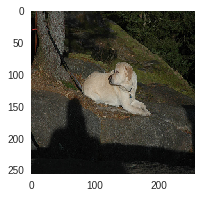

In [9]:
idx = np.random.randint(len(df_list))
file_name = df_list['f'][idx]

size = 256

img_pil = Image.open(path_img+file_name+'.jpg').resize((size, size))
img_np = np.array(img_pil)

print ('shape: ', img_np.shape)

plt.figure(figsize=(5, 3))
plt.imshow(img_np)
plt.grid(False)
plt.show()

mode of class_pil:  P
shape:  (256, 256)
# of 1:  4760
% of 1:  7.26318359375


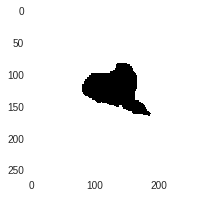

In [10]:
class_id = 12  # 12=dog, 15=person

class_pil = Image.open(path_class+file_name+'.png').resize((size, size))
print ('mode of class_pil: ', class_pil.mode)

class_np = np.array(class_pil)
class_np = np.where(class_np==class_id, 1, 0)
print ('shape: ', class_np.shape)
print ('# of 1: ', np.sum(class_np))
print ('% of 1: ', np.sum(class_np) / size**2 * 100)
#print (class_np[120, 100:])

plt.figure(figsize=(5, 3))
plt.imshow(class_np)
plt.grid(False)
plt.show()

In [11]:
%%time

x = []
y = []
size = 256
class_id = 12  # 12=dog, 15=person

for file_name in tqdm(df_list['f']):
  img_pil = Image.open(path_img+file_name+'.jpg').resize((size, size))
  img_np = np.array(img_pil)
  x.append(img_np)
  
  class_pil = Image.open(path_class+file_name+'.png').resize((size, size))
  class_np = np.array(class_pil)
  class_np = np.where(class_np==class_id, 1, 0)
  class_np = np.expand_dims(class_np, axis=2)
  y.append(class_np)

100%|██████████| 121/121 [00:59<00:00,  2.52it/s]

CPU times: user 1.01 s, sys: 159 ms, total: 1.17 s
Wall time: 59.2 s


Create training data

In [12]:
x = np.array(x)
y = np.array(y)

print ('shape of x: ', x.shape)
print ('shape of y: ', y.shape)

#print (y[0, 250, 100:150, 0])

shape of x:  (121, 256, 256, 3)
shape of y:  (121, 256, 256, 1)


In [0]:
#n_classes = 22

#y = np.where(y == 255, n_classes-1, y)
#y_oh = np.identity(n_classes)[y]

#print ('shape of y: ', y.shape)
#print (y[0][100])

#print ('shape of y_oh: ', y_oh.shape)

In [13]:
x_data = x / 255.0
y_data = y
#y_data = y_oh

x_train, x_valid, y_train, y_valid = train_test_split(x_data, y_data, 
                                                     test_size=0.3, random_state=100)

print ('shape of x_train: ', x_train.shape)
print ('shape of y_train: ', y_train.shape)
print ('shape of x_valid: ', x_valid.shape)
print ('shape of y_valid: ', y_valid.shape)

shape of x_train:  (84, 256, 256, 3)
shape of y_train:  (84, 256, 256, 1)
shape of x_valid:  (37, 256, 256, 3)
shape of y_valid:  (37, 256, 256, 1)


In [0]:
#del df_train, x, y 
#del y_oh

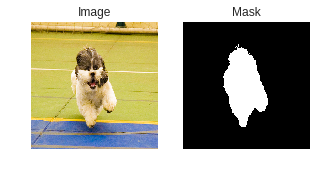

% of 1:  13.8885498046875


In [92]:
idx = np.random.randint(len(x_train))

fig = plt.figure(figsize = (5, 3))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(x_train[idx])
ax1.set_title('Image')
ax1.set_axis_off()

ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(np.squeeze(y_train[idx]), cmap='gray')
ax2.set_title('Mask')
ax2.set_axis_off()

plt.show()

print ('% of 1: ', np.sum(y_train[idx]/size**2 * 100))

In [0]:
#x_train[20, 125, :, 0]
#y_train[20, 125, :, 0]

Model

In [0]:
img_width = size
img_height = size

input_tensor = Input(shape=(img_width, img_height, 3))
    
vgg_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)

In [0]:
#vgg_model.summary()

In [0]:
vgg_top = vgg_model.get_layer('block5_conv2').output

block1_conv2 = vgg_model.get_layer('block1_conv2').output
block2_conv2 = vgg_model.get_layer('block2_conv2').output
block3_conv3 = vgg_model.get_layer('block3_conv3').output
block4_conv3 = vgg_model.get_layer('block4_conv3').output

In [0]:
n_classes = 1
start_neurons = 64

# 8 -> 16
deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding='same')(vgg_top)
uconv4 = concatenate([deconv4, block4_conv3])
uconv4 = Dropout(0.5)(uconv4)
uconv4 = Conv2D(start_neurons * 8, (3, 3), activation='relu', padding='same')(uconv4)
#uconv4 = Conv2D(start_neurons * 8, (3, 3), activation='relu', padding='same')(uconv4)

# 16 -> 32
deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
uconv3 = concatenate([deconv3, block3_conv3])
uconv3 = Dropout(0.5)(uconv3)
uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
#uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

# 32 -> 64
deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
uconv2 = concatenate([deconv2, block2_conv2])
uconv2 = Dropout(0.5)(uconv2)
uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
#uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

# 64 -> 128
deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
uconv1 = concatenate([deconv1, block1_conv2])
uconv1 = Dropout(0.5)(uconv1)
uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
#uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

out = Conv2D(n_classes, (1,1), padding="same", activation="sigmoid")(uconv1)

model = Model(inputs=input_tensor, outputs=out)

#for layer in model.layers[:17]:
#    layer.trainable = False
    
for layer in vgg_model.layers:
    layer.trainable = False    

In [19]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [0]:
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [0]:
early_stopping = EarlyStopping(monitor='val_acc', patience=3, mode='max', 
                              verbose=1)

In [104]:
batch_size = 32
epochs = 10

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_data=(x_valid, y_valid), callbacks=[early_stopping], 
                    verbose=1)

Train on 84 samples, validate on 37 samples
Epoch 1/10
84/84 [==============================] - 8s 91ms/step - loss: 0.2704 - acc: 0.9007 - val_loss: 0.2843 - val_acc: 0.8905
Epoch 2/10
84/84 [==============================] - 7s 89ms/step - loss: 0.2590 - acc: 0.9046 - val_loss: 0.2901 - val_acc: 0.8805
Epoch 3/10
84/84 [==============================] - 7s 89ms/step - loss: 0.2526 - acc: 0.8999 - val_loss: 0.2824 - val_acc: 0.8887
Epoch 4/10
84/84 [==============================] - 7s 89ms/step - loss: 0.2316 - acc: 0.9160 - val_loss: 0.2879 - val_acc: 0.8836
Epoch 00004: early stopping


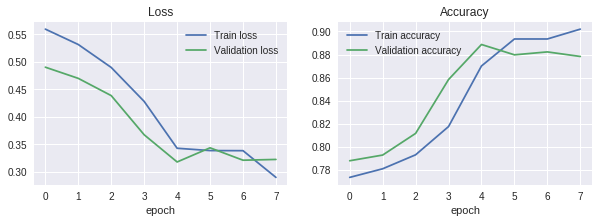

In [94]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(10, 3))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.set_title('Loss')
ax_loss.set_xlabel('epoch')
ax_loss.legend(loc='best')

ax_acc.plot(history.epoch, history.history["acc"], label="Train accuracy")
ax_acc.plot(history.epoch, history.history["val_acc"], label="Validation accuracy")
ax_acc.set_title('Accuracy')
ax_acc.set_xlabel('epoch')
ax_acc.legend(loc='best')
plt.show()

In [122]:
idx = np.random.randint(len(x_valid))

y_valid_prob = model.predict(x_valid[idx:idx+1])
y_valid_pred = (y_valid_prob > 0.5).astype(np.int)

print (y_valid_prob.shape)
#print (y_valid_pred[idx:idx+1, 100, :])
print (np.max(y_valid_pred))
print (np.min(y_valid_pred))

(1, 256, 256, 1)
1
0


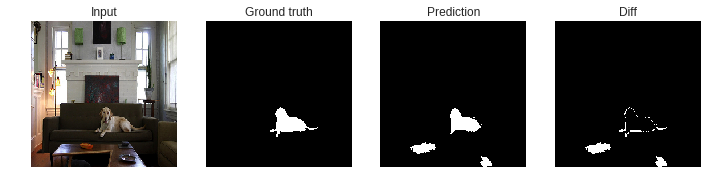

In [123]:
fig = plt.figure(figsize = (12, 5))
ax1 = fig.add_subplot(1, 4, 1)
ax1.imshow(x_valid[idx])
ax1.set_title('Input')
ax1.set_axis_off()

ax2 = fig.add_subplot(1, 4, 2)
ax2.imshow(np.squeeze(y_valid[idx]), cmap='gray')
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3 = fig.add_subplot(1, 4, 3)
ax3.imshow(np.squeeze(y_valid_pred), cmap='gray')
ax3.set_title('Prediction')
ax3.set_axis_off()

ax4 = fig.add_subplot(1, 4, 4)
ax4.imshow(np.abs(np.squeeze(y_valid[idx])-np.squeeze(y_valid_pred)), cmap='gray')
ax4.set_title('Diff')
ax4.set_axis_off()

plt.show()

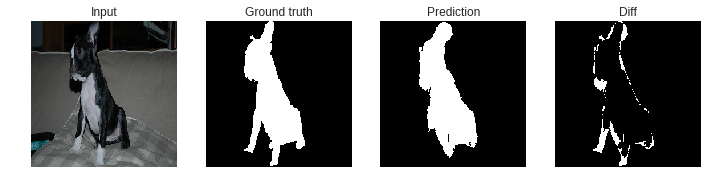

In [109]:
idx = np.random.randint(len(x_train))

y_train_prob = model.predict(x_train[idx:idx+1])
y_train_pred = (y_train_prob > 0.5).astype(np.int)

fig = plt.figure(figsize = (12, 5))
ax1 = fig.add_subplot(1, 4, 1)
ax1.imshow(x_train[idx])
ax1.set_title('Input')
ax1.set_axis_off()

ax2 = fig.add_subplot(1, 4, 2)
ax2.imshow(np.squeeze(y_train[idx]), cmap='gray')
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3 = fig.add_subplot(1, 4, 3)
ax3.imshow(np.squeeze(y_train_pred), cmap='gray')
ax3.set_title('Prediction')
ax3.set_axis_off()

ax4 = fig.add_subplot(1, 4, 4)
ax4.imshow(np.abs(np.squeeze(y_train[idx])-np.squeeze(y_train_pred)), cmap='gray')
ax4.set_title('Diff')
ax4.set_axis_off()

plt.show()